## Motivation

In this notebook, we exame the idea declared in section 1.5.5 on MNIST data, a classification task.

In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.losses import MSE
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from utils import GradientRelativeEntropy

tf.random.set_seed(42)

## The MNIST Data

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32').reshape([-1, 28*28]) / 255.0
x_test = x_test.astype('float32').reshape([-1, 28*28]) / 255.0
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

## Train a Model with Gradient Loss

In [3]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(10, 'softmax')
])

gradient_loss_fn = GradientRelativeEntropy(model)

In [4]:
optimizer = tf.optimizers.Adam()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        loss = gradient_loss_fn(x, y)
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss

In [5]:
def evaluate(model):
    return accuracy_score(y_test, tf.argmax(model(x_test), axis=1))

In [6]:
ds = tf.data.Dataset.from_tensor_slices(
    (x_train, tf.one_hot(y_train, 10))
)
ds = ds.batch(100)

In [7]:
for epoch in range(20):
    for x, y in ds:
        loss = train_step(x, y)
    print(epoch, loss.numpy(), evaluate(model))

0 0.014201277 0.9384
1 0.013840504 0.9547
2 0.0134777725 0.9618
3 0.013813006 0.9635
4 0.0138682425 0.9648
5 0.013393953 0.9664
6 0.013393424 0.9721
7 0.013383634 0.9708
8 0.013384362 0.9694
9 0.01338481 0.971
10 0.013382006 0.9746
11 0.013385767 0.9761
12 0.014054268 0.9738
13 0.013527642 0.9778
14 0.014172536 0.9691
15 0.013518685 0.9745
16 0.013990302 0.9724
17 0.013539702 0.9753
18 0.013374265 0.9728
19 0.013370821 0.9757


In [8]:
evaluate(model)

0.9757

## Baseline Model with Usual Loss

In [9]:
baseline_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, 'softmax')
])

In [10]:
baseline_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [11]:
baseline_model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    verbose=2,
)

Epoch 1/20
1875/1875 - 2s - loss: 0.2315 - accuracy: 0.9317 - val_loss: 0.1437 - val_accuracy: 0.9551 - 2s/epoch - 1ms/step
Epoch 2/20
1875/1875 - 2s - loss: 0.0966 - accuracy: 0.9706 - val_loss: 0.1010 - val_accuracy: 0.9681 - 2s/epoch - 949us/step
Epoch 3/20
1875/1875 - 2s - loss: 0.0695 - accuracy: 0.9786 - val_loss: 0.0777 - val_accuracy: 0.9750 - 2s/epoch - 973us/step
Epoch 4/20
1875/1875 - 2s - loss: 0.0522 - accuracy: 0.9826 - val_loss: 0.0912 - val_accuracy: 0.9739 - 2s/epoch - 951us/step
Epoch 5/20
1875/1875 - 2s - loss: 0.0402 - accuracy: 0.9874 - val_loss: 0.0994 - val_accuracy: 0.9728 - 2s/epoch - 951us/step
Epoch 6/20
1875/1875 - 2s - loss: 0.0339 - accuracy: 0.9890 - val_loss: 0.0898 - val_accuracy: 0.9768 - 2s/epoch - 1ms/step
Epoch 7/20
1875/1875 - 2s - loss: 0.0266 - accuracy: 0.9913 - val_loss: 0.0893 - val_accuracy: 0.9767 - 2s/epoch - 975us/step
Epoch 8/20
1875/1875 - 2s - loss: 0.0245 - accuracy: 0.9914 - val_loss: 0.0997 - val_accuracy: 0.9749 - 2s/epoch - 978us/s

In [12]:
evaluate(baseline_model)

0.9779

## Model Robustness

Now, we compare the robustness of the model and the baseline. To do so, we add Gaussian noise to the test data and check the accuracy.

In [25]:
stddevs, model_accs, baseline_accs = [], [], []
for stddev in tqdm(np.linspace(0, 0.5, 50)):
    stddevs.append(stddev)
    x_test_noised = x_test + tf.random.normal(tf.shape(x_test)) * stddev
    model_accs.append(
        accuracy_score(y_test, tf.argmax(model(x_test_noised), axis=1))
    )
    baseline_accs.append(
        accuracy_score(y_test, tf.argmax(baseline_model(x_test_noised), axis=1))
    )

100%|████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.66it/s]


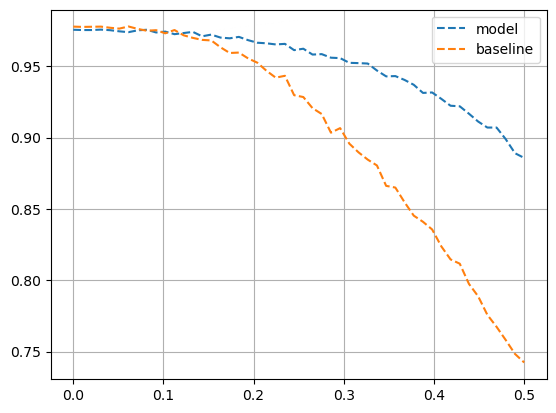

In [26]:
plt.plot(stddevs, model_accs, '--', label='model')
plt.plot(stddevs, baseline_accs, '--', label='baseline')
plt.legend()
plt.grid()
plt.show()

## Conclusion

By simply using the "gradient loss", we obtain a result that approaches the baseline. But the robustness is greatly out-performs the baseline.